## Asycronous client example

This example illustrates how one can work with asyncronous clients using the FEDn SDK.

### ML model

In [158]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score


# We generate a simulated dataset for classification
X, y = make_classification(n_samples=1000, n_features=4, random_state=42)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [175]:
clf = MLPClassifier(hidden_layer_sizes=(5, 2), activation='relu')
clf.fit(X_train, y_train)

print("Training accuracy: ", accuracy_score(y_train, clf.predict(X_train)))
print("Test accuracy: ", accuracy_score(y_test, clf.predict(X_test)))

Training accuracy:  0.8656716417910447
Test accuracy:  0.8696969696969697


/Users/andreash/miniforge3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [167]:
from fedn import APIClient
from fedn.network.clients.client import Client
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import collections
import copy

We make a client connection to the FEDn API service. Here we assume that FEDn is deployed locally in pseudo-distributed mode with default ports.

In [164]:
DISCOVER_HOST = '127.0.0.1'
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

Initialize FEDn with the compute package and seed model. Note that these files needs to be created separately by follwing instructions in the README.

In [8]:
client.set_package('package.tgz', 'numpyhelper')
client.set_initial_model('seed.npz')
seed_model = client.get_initial_model()

Next we start a training session using FedAvg:

In [74]:
session_config_fedavg = {
                    "helper": "numpyhelper",
                    "session_id": "experiment_fedavg6",
                    "aggregator": "fedavg",
                    "model_id": seed_model['model_id'],
                    "rounds": 1,
                 }

result_fedavg = client.start_session(**session_config_fedavg)

Next, we retrive all model validations from all clients, extract the training accuracy metric, and compute its mean value accross all clients

In [186]:
models = client.list_models(session_id = "ea841201-2606-4397-b1c5-6078ef83a029")

validations = []
acc = collections.OrderedDict()
for model in models["result"]:
    model_id = model["model"]
    validations = client.list_validations(modelId=model_id)

    for _ , validation in validations.items(): 
        metrics = json.loads(validation['data'])
        try:
            acc[model_id].append(metrics['accuracy_score'])
        except KeyError: 
            acc[model_id] = [metrics['accuracy_score']]
            
mean_acc_fedavg = []
for model, data in acc.items():
    mean_acc_fedavg.append(np.mean(data))
mean_acc_fedavg.reverse()

Finally, plot the result.

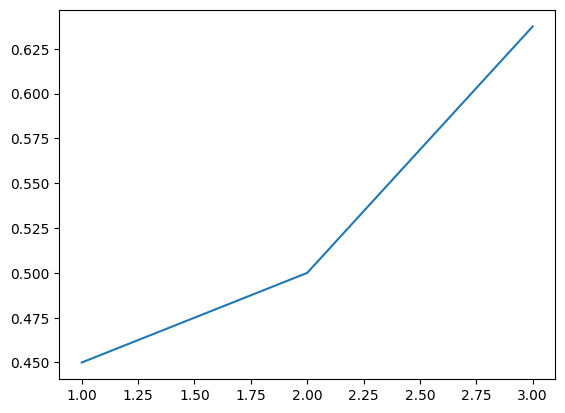

In [187]:
x = range(1,len(mean_acc_fedavg)+1)
plt.plot(x, mean_acc_fedavg)